In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from numpy import asarray
import matplotlib.pyplot as plt
import imageio
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from skimage.segmentation import mark_boundaries
import lime
from lime import lime_image

In [2]:
TRAIN_DIR = 'D:/Minor Project/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train'
TEST_DIR = 'D:/Minor Project/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation'


In [3]:
HEIGHT = 300
WIDTH = 300
BATCH_SIZE = 8
class_list = ["class_1", "class_2"]
NUM_EPOCHS = 2


In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(HEIGHT, WIDTH, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_list), activation='softmax'))


In [5]:
adam = Adam()
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])


In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=90,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.1)

In [7]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=90,
                                  horizontal_flip=True,
                                  vertical_flip=False)


In [8]:
train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE)


Found 520 images belonging to 2 classes.


In [9]:
test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size=(HEIGHT, WIDTH),
                                                  batch_size=BATCH_SIZE)


Found 130 images belonging to 2 classes.


In [10]:
history = model.fit_generator(generator=train_generator, epochs=NUM_EPOCHS, steps_per_epoch=15,
                              shuffle=True, validation_data=test_generator)


C:\Users\ianuj\AppData\Local\Temp\ipykernel_18304\726686260.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator, epochs=NUM_EPOCHS, steps_per_epoch=15,


Epoch 1/2
15/15 [==============================] - 30s 2s/step - loss: 0.9589 - accuracy: 0.6833 - val_loss: 0.5847 - val_accuracy: 0.7385
Epoch 2/2
15/15 [==============================] - 25s 2s/step - loss: 0.5539 - accuracy: 0.7917 - val_loss: 0.5717 - val_accuracy: 0.7385


In [11]:
model.save("lenet_model.h5")

C:\Users\ianuj\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
score = model.evaluate_generator(test_generator)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])


C:\Users\ianuj\AppData\Local\Temp\ipykernel_18304\3271344810.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(test_generator)


Test Loss: 0.5798883438110352
Test Accuracy: 0.7384615540504456


In [13]:
test_generator.reset() 

In [14]:

predictions = model.predict_generator(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

C:\Users\ianuj\AppData\Local\Temp\ipykernel_18304\1163538438.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)


In [15]:
true_classes = test_generator.classes

In [16]:
confusion = confusion_matrix(true_classes, predicted_classes)

print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[96  0]
 [34  0]]


In [17]:
from sklearn.metrics import confusion_matrix, classification_report

report = classification_report(true_classes, predicted_classes, target_names=class_list)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     class_1       0.74      1.00      0.85        96
     class_2       0.00      0.00      0.00        34

    accuracy                           0.74       130
   macro avg       0.37      0.50      0.42       130
weighted avg       0.55      0.74      0.63       130



C:\Users\ianuj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ianuj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ianuj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


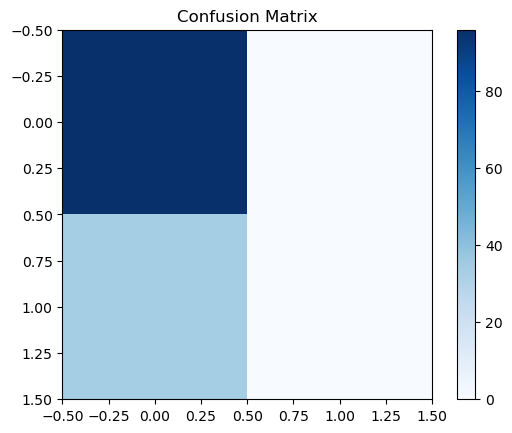

In [18]:
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

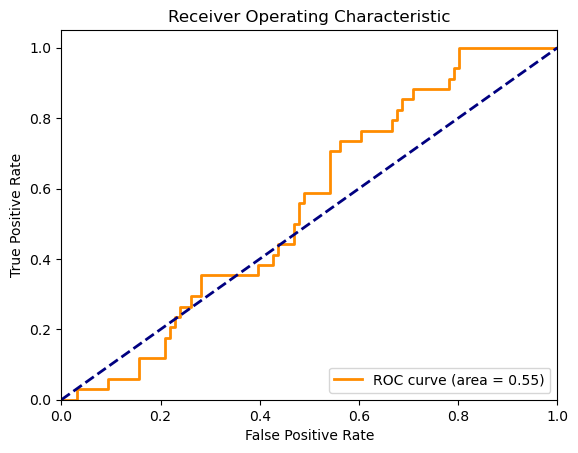

In [20]:
fpr, tpr, thresholds = roc_curve(true_classes, predictions[:, 1])  
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [21]:
explainer = lime_image.LimeImageExplainer()

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define a simple CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Assuming 2 classes for binary classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Found 520 images belonging to 2 classes.
17/17 [==============================] - 29s 2s/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 106ms/step


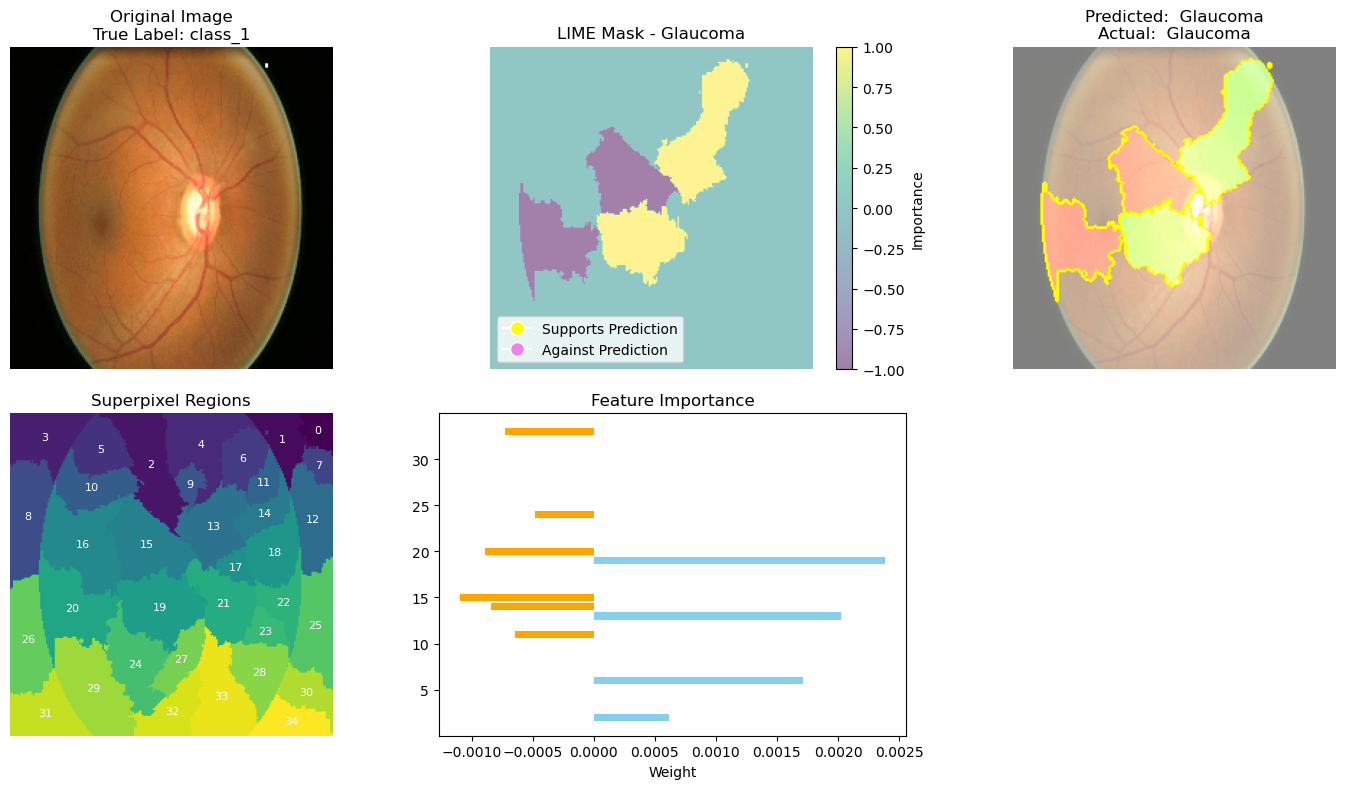

In [27]:
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.lines as mlines
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a function to generate the desired outputs for a given image index
def generate_outputs(image_index, predicted_classes, true_classes):
    # Choose a specific image from your test dataset to explain
    image = test_generator[image_index][0][0]

    # Explain the model's prediction for the chosen image
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image, model.predict, top_labels=1)

    # Get the actual and predicted class labels
    actual_label = class_list[true_classes[image_index]]
    predicted_label = class_list[predicted_classes[image_index]]

    # Display the LIME mask with color representation and labels
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)

    plt.figure(figsize=(15, 8))  # Adjust the figure size as needed

    # Original Image
    plt.subplot(2, 3, 1)
    plt.imshow(image)
    plt.title(f"Original Image\nTrue Label: {actual_label}")
    plt.axis('off')

    # LIME Mask - Glaucoma
    plt.subplot(2, 3, 2)
    cmap = 'viridis'
    supports_prediction_color = 'yellow'
    against_prediction_color = 'violet'

    # Choose appropriate labels based on the model predictions
    prediction_label = 'Glaucoma' if predicted_classes[image_index] == 0 else 'Normal'

    mask_image = plt.imshow(mask, cmap=cmap, alpha=0.5)
    plt.title("LIME Mask - {}".format(prediction_label))
    colorbar = plt.colorbar(mask_image)
    colorbar.set_label('Importance')

    # Add legend to the mask image
    legend_elements = [mlines.Line2D([0], [0], marker='o', color='w', label='Supports Prediction', markerfacecolor=supports_prediction_color, markersize=10),
                       mlines.Line2D([0], [0], marker='o', color='w', label='Against Prediction', markerfacecolor=against_prediction_color, markersize=10)]
    plt.legend(handles=legend_elements, loc='lower left')
    plt.axis('off')

    
    # Predicted - Glaucoma, Ground Truth - Glaucoma
    plt.subplot(2, 3, 3)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f"Predicted: {'Glaucoma' if predicted_classes[image_index] == 1 else ' Glaucoma'}\nActual: {'Glaucoma' if actual_label == 1 else ' Glaucoma'}")
    plt.axis('off')



    # Display the superpixel regions with numbers
    superpixel_regions = explanation.segments
    plt.subplot(2, 3, 4)
    plt.imshow(superpixel_regions, cmap='viridis')

    # Add numbers inside each superpixel
    for i in range(superpixel_regions.max() + 1):
        y, x = np.where(superpixel_regions == i)
        plt.text(x.mean(), y.mean(), str(i), color='white', fontsize=8, ha='center', va='center')

    plt.title('Superpixel Regions')
    plt.axis('off')

    # Display the top 10 superpixel regions with numbers
    top_features = [str(f[0]) if isinstance(f[0], int) else f[0] for f in explanation.local_exp[explanation.top_labels[0]][:10]]  # Get top 10 features
    top_weights = [f[1] for f in explanation.local_exp[explanation.top_labels[0]][:10]]  # Get top 10 weights

    # Separate positive and negative features
    positive_features = [feature for feature, weight in zip(top_features, top_weights) if weight > 0]
    positive_weights = [weight for weight in top_weights if weight > 0]
    negative_features = [feature for feature, weight in zip(top_features, top_weights) if weight < 0]
    negative_weights = [weight for weight in top_weights if weight < 0]

    # Plot the positive and negative weights with color differentiation
    plt.subplot(2, 3, 5)

    # Plot positive weights (Normal) on the left in blue
    plt.barh(positive_features, positive_weights, color='skyblue', align='center')

    # Plot negative weights (Glaucoma) on the right in orange
    plt.barh(negative_features, negative_weights, color='orange', align='center')

    plt.xlabel('Weight')
    plt.title('Feature Importance')
    plt.tight_layout()  # Adjust layout to prevent overlapping

    # Show the plots
    plt.show()

# Assuming you have a model named 'model'
# Assuming you have a test directory with images
test_directory = 'D:\Minor Project\Fundus_Train_Val_Data\Fundus_Scanes_Sorted\Train'
batch_size = 32

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),  # Adjust based on your model's input size
    batch_size=batch_size,
    class_mode='categorical',  # Assuming you have a classification problem
    shuffle=False  # Keep the order for explanations
)

# Make predictions using the model on the test data
predictions = model.predict(test_generator)

# Extract predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Assuming you have ground truth labels
true_classes = test_generator.classes

# Choose an image index to generate outputs for
image_index_to_explain = 0
generate_outputs(image_index_to_explain, predicted_classes, true_classes)